# Fibit Time Series independent project

## Deliverables

1. This notebook containing your analysis, summary, and conclusions


2. A tidied data set. The source data is a little messy the data was edited in Google Sheets then downloaded into a csv for upload here.


3. A summarization of the data.
    - What do you make of the data?
    - What can you say say about the individual who was wearing this fitness tracker?   
   [Jump to Summary and Conclusions](#Summary)     
  
  
4. Predictions for the missing two weeks worth of data in a separate csv file.


## Environment Setup

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# plotting defaults
plt.rc('figure', figsize=(13, 7))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

# Acquire

In [3]:
df = pd.read_csv('fitbit_all_activity.csv')

In [4]:
df.head()

,date,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
0,2018-04-26,2635,2931,1,2,1347,93,0,0,566
1,2018-04-27,3649,9971,5,19,1158,219,46,17,1752
2,2018-04-28,3379,3521,2,2,702,155,22,11,1124
3,2018-04-29,2851,1639,1,0,891,122,0,0,602
4,2018-04-30,2825,1323,1,0,880,104,0,0,540


# Prepare

In [5]:
df1 = df.copy()
df1.date = pd.to_datetime(df1.date)
df1 = df1.set_index('date').sort_index()
df1.head()

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
date,,,,,,,,,
2018-04-26,2635,2931,1,2,1347,93,0,0,566
2018-04-27,3649,9971,5,19,1158,219,46,17,1752
2018-04-28,3379,3521,2,2,702,155,22,11,1124
2018-04-29,2851,1639,1,0,891,122,0,0,602
2018-04-30,2825,1323,1,0,880,104,0,0,540


In [6]:
df1.isna().sum()

cal_burned      0
steps           0
distance        0
floors          0
min_sed         0
min_light       0
min_fair        0
min_very        0
activity_cal    0
dtype: int64

In [7]:
df1.info()
# need to convert all columns to numbers, fixed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 225 entries, 2018-04-26 to 2018-12-06
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   cal_burned    225 non-null    int64
 1   steps         225 non-null    int64
 2   distance      225 non-null    int64
 3   floors        225 non-null    int64
 4   min_sed       225 non-null    int64
 5   min_light     225 non-null    int64
 6   min_fair      225 non-null    int64
 7   min_very      225 non-null    int64
 8   activity_cal  225 non-null    int64
dtypes: int64(9)
memory usage: 17.6 KB


array([[<AxesSubplot:title={'center':'cal_burned'}>,
        <AxesSubplot:title={'center':'steps'}>,
        <AxesSubplot:title={'center':'distance'}>],
       [<AxesSubplot:title={'center':'floors'}>,
        <AxesSubplot:title={'center':'min_sed'}>,
        <AxesSubplot:title={'center':'min_light'}>],
       [<AxesSubplot:title={'center':'min_fair'}>,
        <AxesSubplot:title={'center':'min_very'}>,
        <AxesSubplot:title={'center':'activity_cal'}>]], dtype=object)

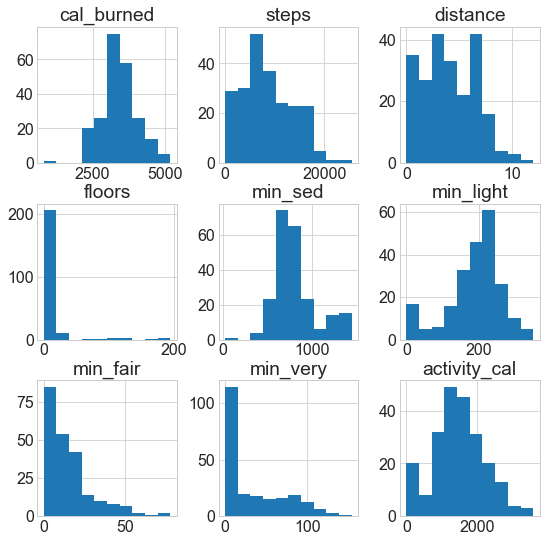

In [8]:
# view histograms - ok before split b/c all independent
df1.hist(figsize=(9, 9))

## split and validate split

In [9]:
# split data
train_size = int(len(df1) * .5)
validate_size = int(len(df1) * .3)
test_size = int(len(df1) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df1[: train_size]
validate = df1[train_size : validate_end_index]
test = df1[validate_end_index : ]

In [10]:
# Does the length of each df equate to the length of the original df?
print(len(train) + len(validate) + len(test) == len(df))

True


In [11]:
# Does the first row of original df equate to the first row of train?
print(df1.head(1) == train.head(1))

            cal_burned  steps  distance  floors  min_sed  min_light  min_fair  \
date                                                                            
2018-04-26        True   True      True    True     True       True      True   

            min_very  activity_cal  
date                                
2018-04-26      True          True  


In [12]:
# Is the last row of train the day before the first row of validate? And the same for validate to test?
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
date,,,,,,,,,
2018-10-21,3991,16642,8,15,437,349,33,58,2485
2018-10-22,3149,8328,4,7,747,172,4,28,1239


In [13]:
# Is the last row of test the same as the last row of our original dataframe?
pd.concat([test.tail(1), df1.tail(1)])

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal
date,,,,,,,,,
2018-12-06,3669,14774,7,9,647,198,4,78,1962
2018-12-06,3669,14774,7,9,647,198,4,78,1962


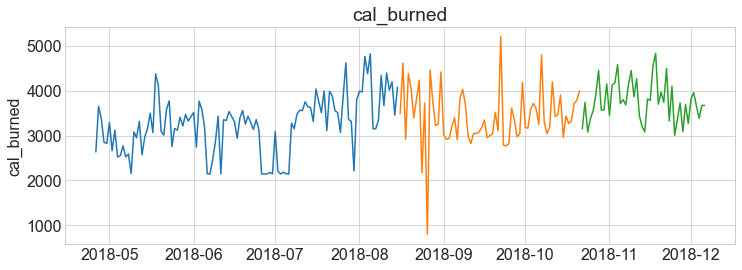

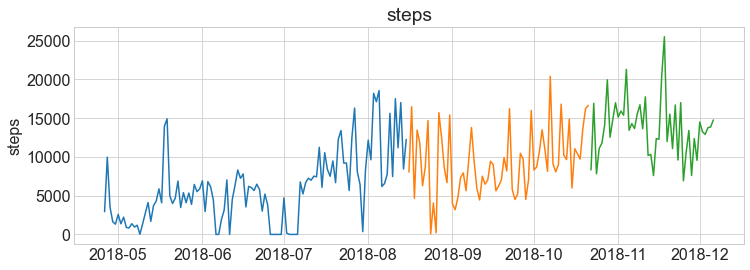

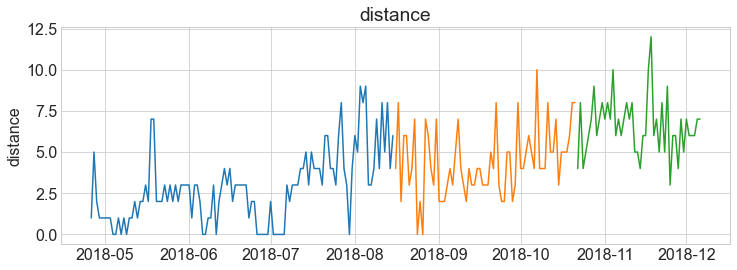

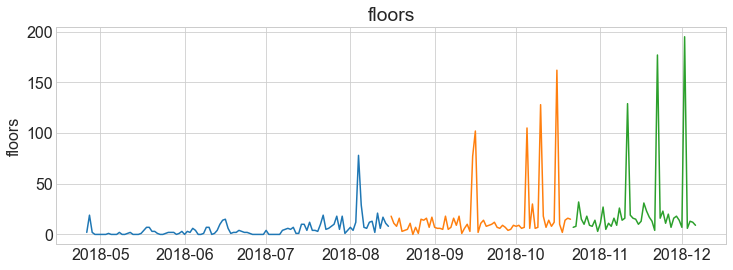

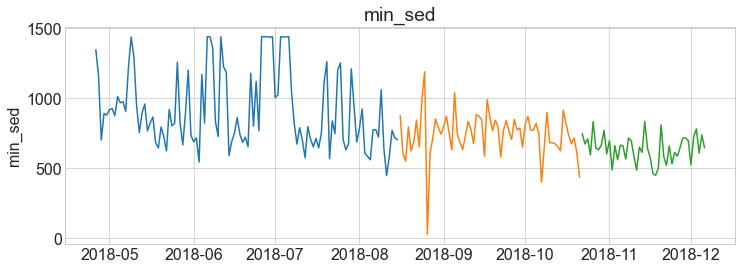

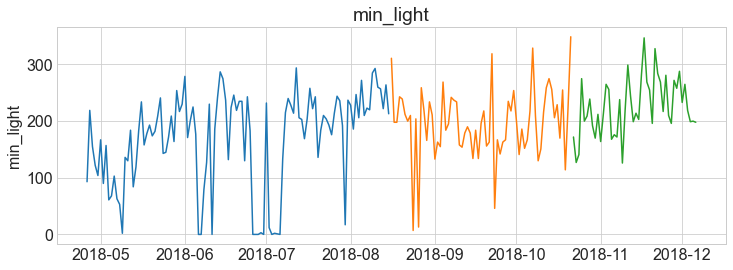

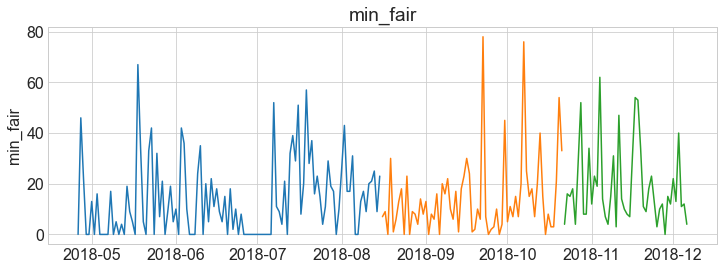

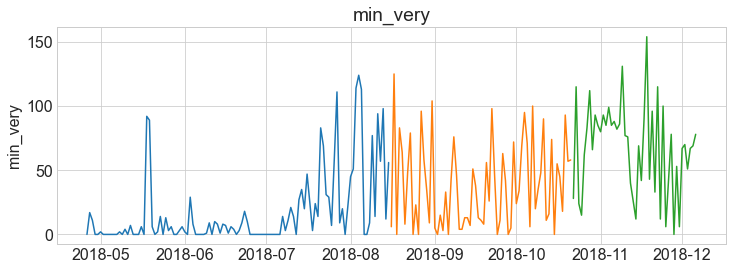

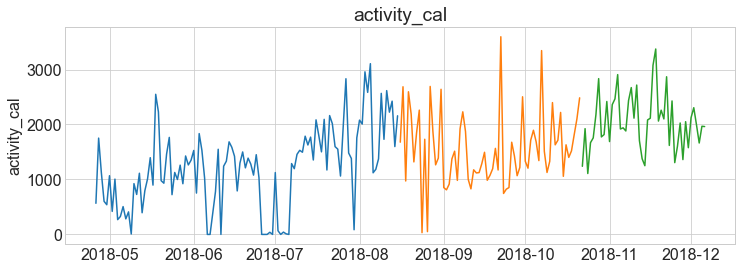

In [14]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

# Explore

In [15]:
cb = train.cal_burned
cb.head()

date
2018-04-26    2635
2018-04-27    3649
2018-04-28    3379
2018-04-29    2851
2018-04-30    2825
Name: cal_burned, dtype: int64

In [16]:
steps = train.steps
steps.head()

date
2018-04-26    2931
2018-04-27    9971
2018-04-28    3521
2018-04-29    1639
2018-04-30    1323
Name: steps, dtype: int64

<AxesSubplot:ylabel='Frequency'>

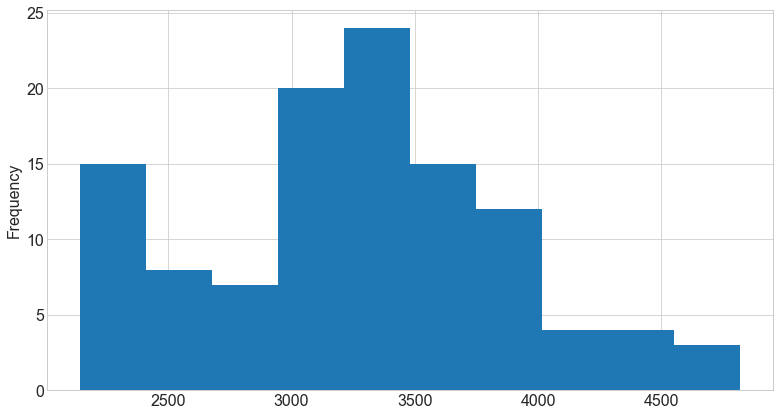

In [17]:
cb.plot.hist()

<AxesSubplot:ylabel='Frequency'>

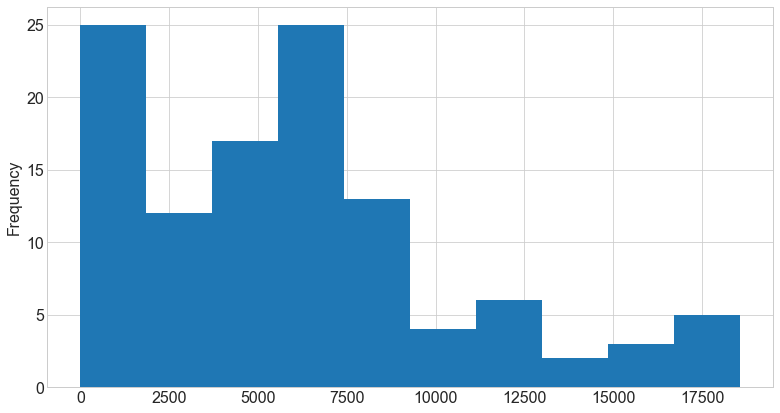

In [18]:
steps.plot.hist()

In [19]:
type(train.index)

pandas.core.indexes.datetimes.DatetimeIndex

<AxesSubplot:xlabel='month'>

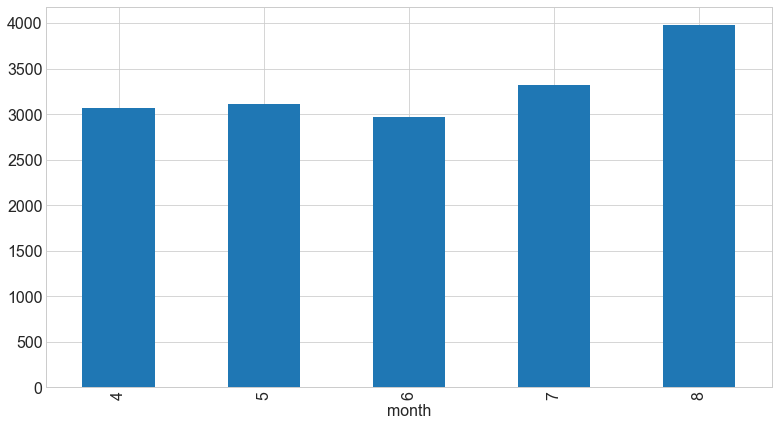

In [20]:
train['month'] = train.index.month
train.groupby('month').cal_burned.mean().plot.bar()

<AxesSubplot:xlabel='month'>

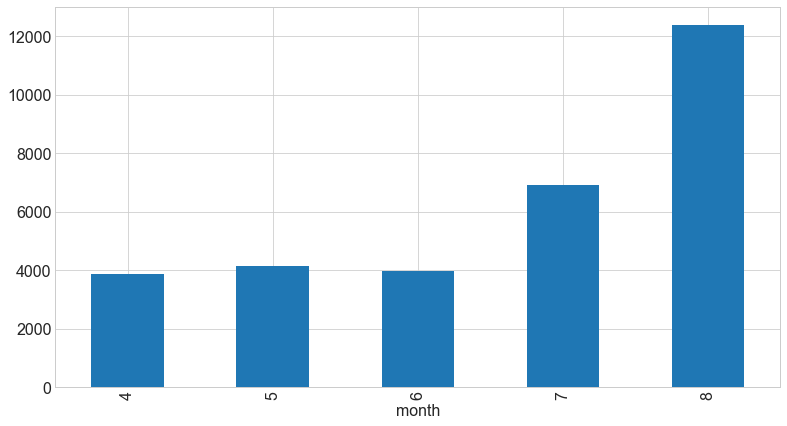

In [21]:
train.groupby('month').steps.mean().plot.bar()

<AxesSubplot:xlabel='weekday', ylabel='cal_burned'>

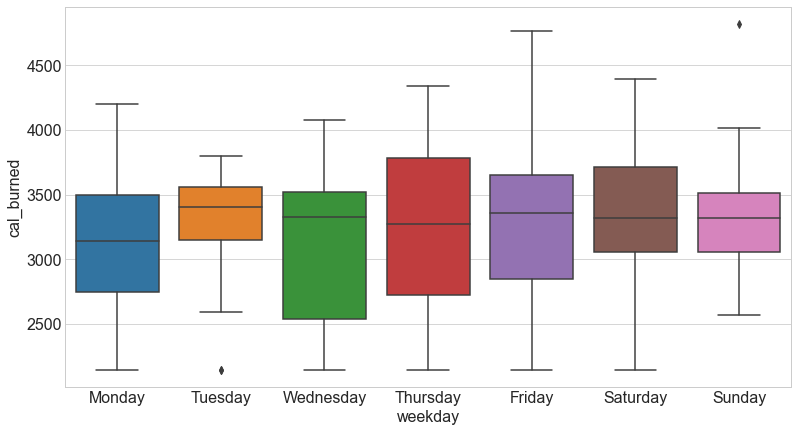

In [22]:
train['weekday'] = train.index.day_name()
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(data=train, y='cal_burned', x='weekday', order=order)

<AxesSubplot:xlabel='weekday', ylabel='steps'>

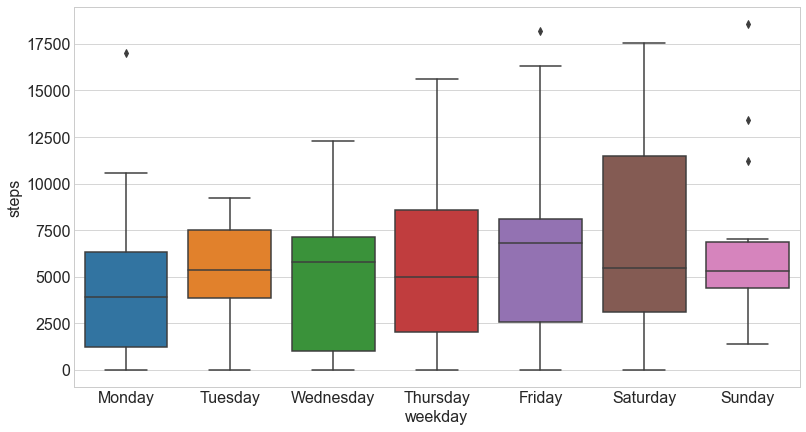

In [23]:
sns.boxplot(data=train, y='steps', x='weekday', order=order)

<AxesSubplot:xlabel='weekday', ylabel='min_sed'>

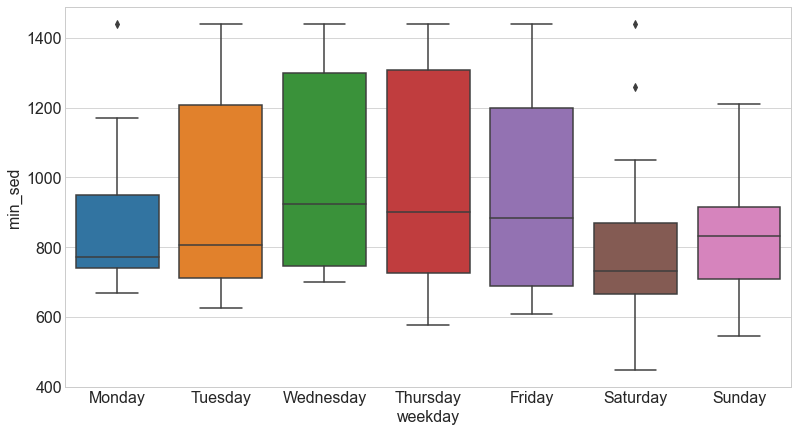

In [24]:
sns.boxplot(data=train, y='min_sed', x='weekday', order=order)

<AxesSubplot:xlabel='weekday', ylabel='min_light'>

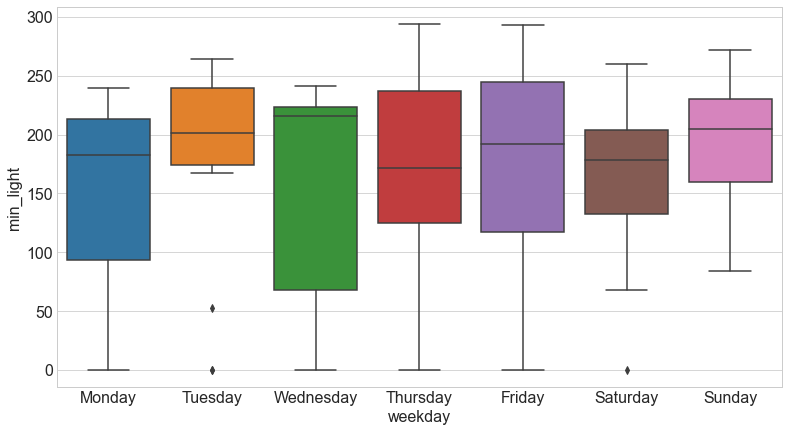

In [25]:
sns.boxplot(data=train, y='min_light', x='weekday', order=order)

<AxesSubplot:xlabel='weekday', ylabel='min_fair'>

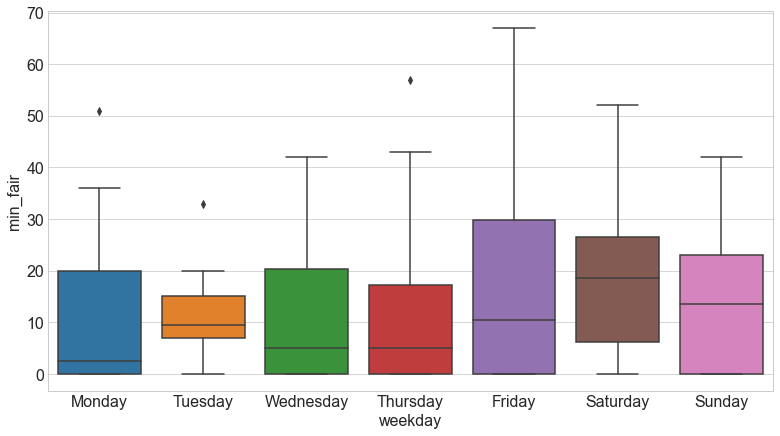

In [26]:
sns.boxplot(data=train, y='min_fair', x='weekday', order=order)

<AxesSubplot:xlabel='weekday', ylabel='min_very'>

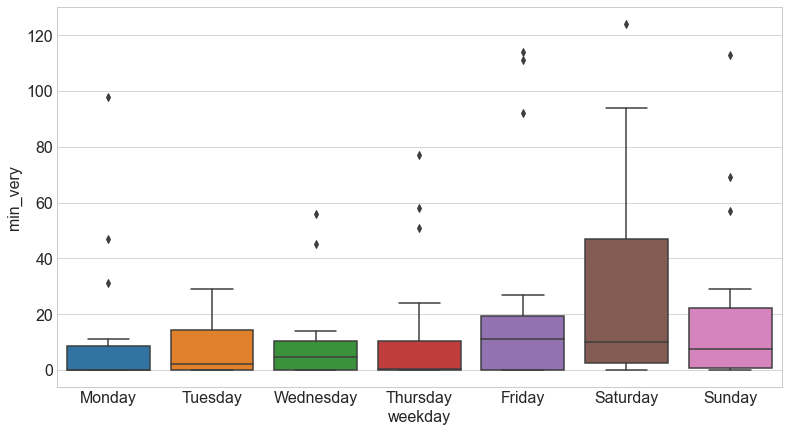

In [27]:
sns.boxplot(data=train, y='min_very', x='weekday', order=order)

<AxesSubplot:xlabel='date'>

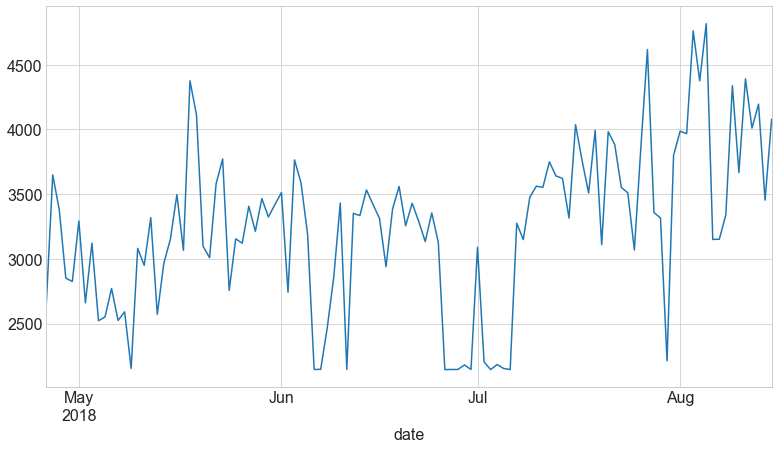

In [28]:
cb.plot()

<AxesSubplot:title={'center':'3 Day average'}, xlabel='date'>

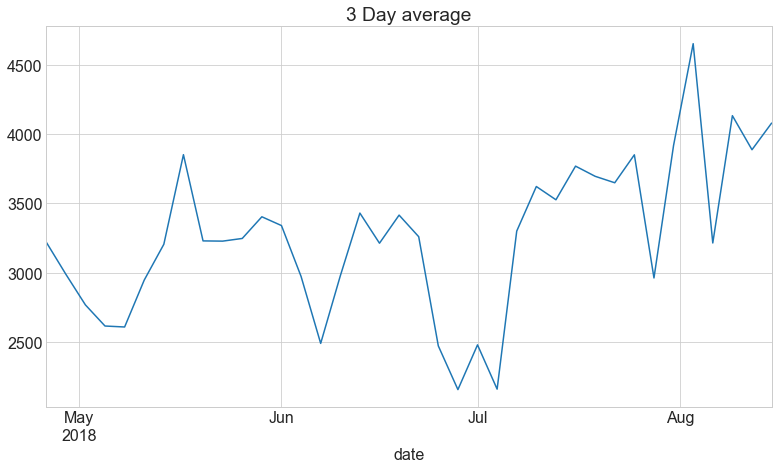

In [29]:
cb.resample('3D').mean().plot(title='3 Day average')

<AxesSubplot:title={'center':'week average'}, xlabel='date'>

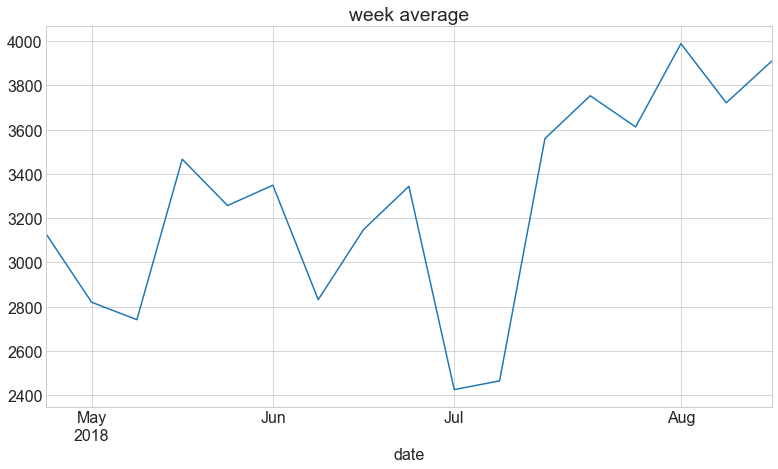

In [30]:
cb.resample('W').mean().plot(title='week average')

In [31]:
steps = train.steps
steps.head()

date
2018-04-26    2931
2018-04-27    9971
2018-04-28    3521
2018-04-29    1639
2018-04-30    1323
Name: steps, dtype: int64

<AxesSubplot:xlabel='date'>

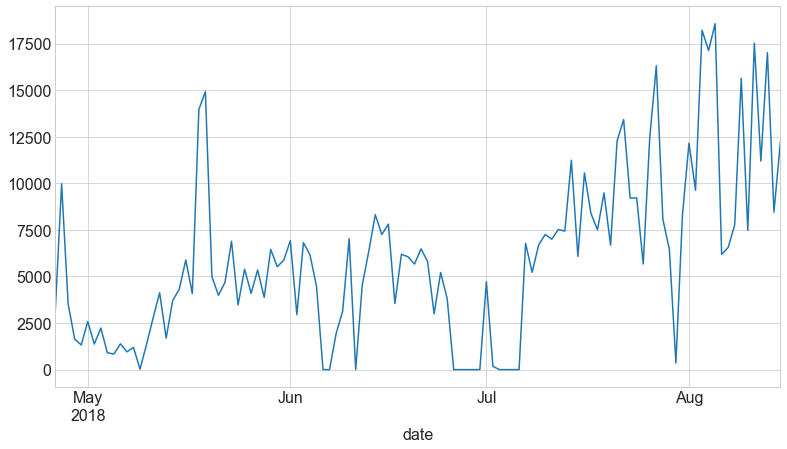

In [32]:
steps.plot()

<AxesSubplot:title={'center':'3 Day average'}, xlabel='date'>

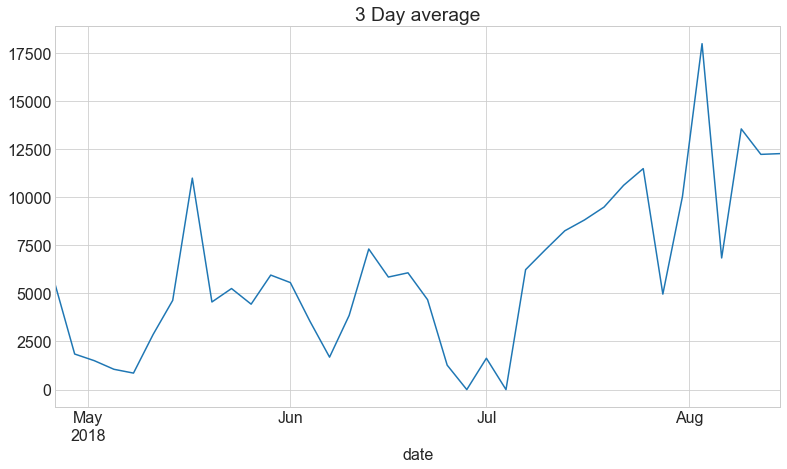

In [33]:
steps.resample('3D').mean().plot(title='3 Day average')

<AxesSubplot:title={'center':'week average'}, xlabel='date'>

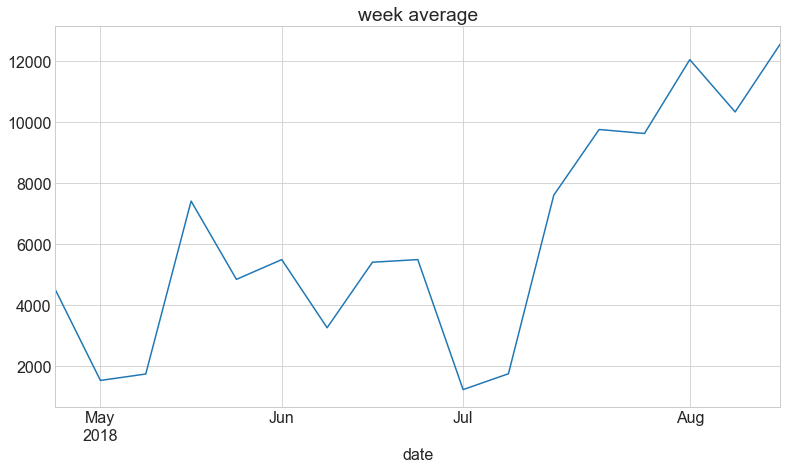

In [34]:
steps.resample('W').mean().plot(title='week average')

Text(0.5, 1.0, 'Lag plot with lag=1')

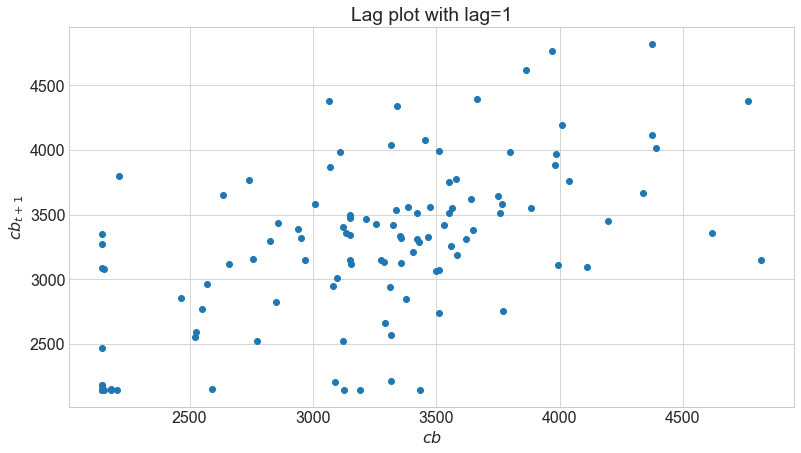

In [35]:
plt.scatter(cb, cb.shift(-1))
plt.xlabel('$cb$')
plt.ylabel('$cb_{t + 1}$')
plt.title('Lag plot with lag=1')

In [36]:
# del train['cb(t + 1)']
# del train['month']
train.head()

,cal_burned,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal,month,weekday
date,,,,,,,,,,,
2018-04-26,2635,2931,1,2,1347,93,0,0,566,4,Thursday
2018-04-27,3649,9971,5,19,1158,219,46,17,1752,4,Friday
2018-04-28,3379,3521,2,2,702,155,22,11,1124,4,Saturday
2018-04-29,2851,1639,1,0,891,122,0,0,602,4,Sunday
2018-04-30,2825,1323,1,0,880,104,0,0,540,4,Monday


<AxesSubplot:xlabel='date'>

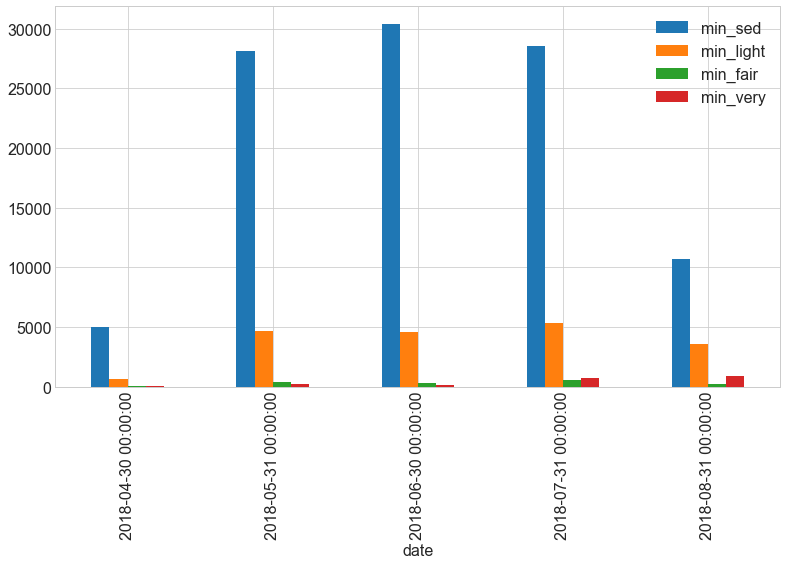

In [37]:
train[['min_sed', 'min_light', 'min_fair', 'min_very']].resample('M').sum().plot.bar()

,this_week,steps,distance,floors,min_sed,min_light,min_fair,min_very,activity_cal,month,the_next_week
date,,,,,,,,,,,
2018-04-29,3128.500000,4515.500000,2.250000,5.750000,1024.500000,147.250000,17.000000,7.000000,1011.000000,4.000000,2820.285714
2018-05-06,2820.285714,1518.285714,0.714286,0.142857,937.000000,107.142857,4.142857,0.285714,590.571429,4.857143,2741.285714
2018-05-13,2741.285714,1729.857143,0.857143,0.714286,1065.571429,93.142857,3.714286,1.857143,551.285714,5.000000,3466.714286
2018-05-20,3466.714286,7406.571429,3.571429,3.142857,791.571429,177.000000,19.857143,27.571429,1407.571429,5.000000,3257.285714
2018-05-27,3257.285714,4836.571429,2.428571,1.285714,854.428571,185.857143,19.285714,5.428571,1180.857143,5.000000,3349.000000
2018-06-03,3349.000000,5485.428571,2.571429,1.571429,779.285714,216.571429,12.142857,5.714286,1296.428571,5.428571,2831.571429
2018-06-10,2831.571429,3248.000000,1.428571,3.571429,1114.000000,119.714286,15.000000,2.571429,752.857143,6.000000,3148.714286
2018-06-17,3148.714286,5399.142857,2.571429,7.142857,963.571429,194.000000,12.142857,5.000000,1151.000000,6.000000,3344.285714
2018-06-24,3344.285714,5485.571429,2.571429,2.285714,843.857143,218.857143,7.142857,7.142857,1314.857143,6.000000,2425.142857


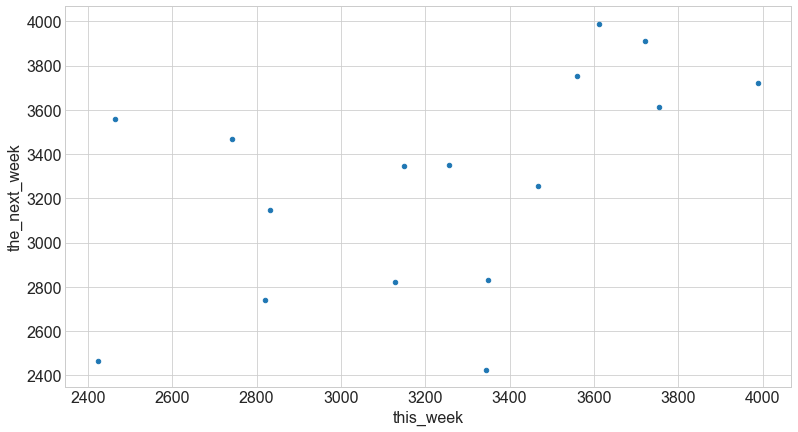

In [38]:
weekly = train.resample('W').mean()
weekly['the_next_week'] = weekly.cal_burned.shift(-1)
weekly = weekly.rename(columns={'cal_burned': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

**Takeaways**     
- there is not a cyclical/seasonal pattern to this data
- slight linear upward trend
- dataset is too small for cycle or seasonal trend to show

# Model

## Functions to help with modeling

In [39]:
# evaluation function to compute rmse
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

# plot and evaluate 
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()
    
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecasting

### Last Observed Value

In [40]:
# remove columns not needed for modeling from train
del train['distance']
del train['floors']
del train['activity_cal']
del train['month']
del train['weekday']

# remove columns not needed for modeling from validate
del validate['distance']
del validate['floors']
del validate['activity_cal']

# remove columns not needed for modeling from test
del test['distance']
del test['floors']
del test['activity_cal']

train.head()

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-04-26,2635,2931,1347,93,0,0
2018-04-27,3649,9971,1158,219,46,17
2018-04-28,3379,3521,702,155,22,11
2018-04-29,2851,1639,891,122,0,0
2018-04-30,2825,1323,880,104,0,0


In [41]:
# get last observed value and set that as prediction for all in validate
cal_burned = train['cal_burned'][-1:][0]
steps = train['steps'][-1:][0]
min_sed = train['min_sed'][-1:][0]
min_light = train['min_light'][-1:][0]
min_fair = train['min_fair'][-1:][0]
min_very = train['min_very'][-1:][0]

yhat_df = pd.DataFrame({'cal_burned': [cal_burned], 'steps': [steps], 'min_sed': [min_sed], 
                        'min_light': [min_light], 'min_fair': [min_fair], 'min_very': [min_very]}, 
                       index = validate.index)

yhat_df.head(2)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-08-16,4079,12259,704,213,23,56
2018-08-17,4079,12259,704,213,23,56


In [42]:
train.tail(1)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-08-15,4079,12259,704,213,23,56


cal_burned -- RMSE: 921


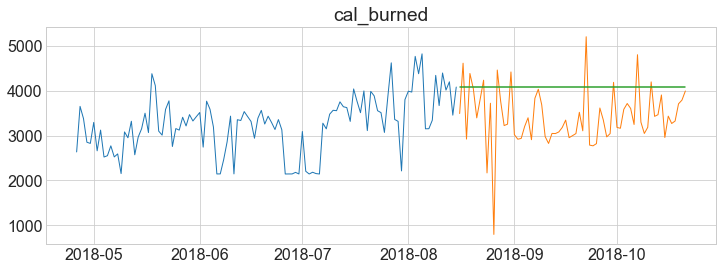

steps -- RMSE: 5156


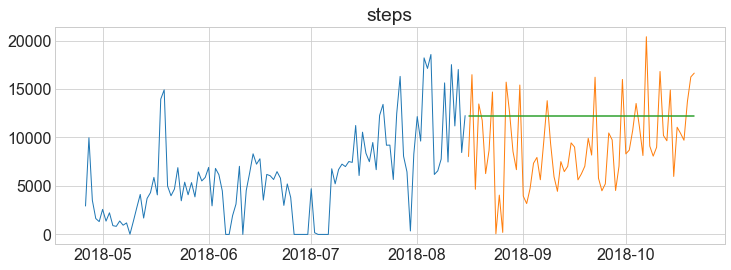

min_sed -- RMSE: 163


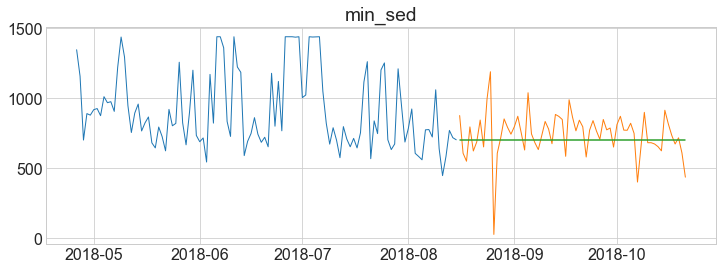

min_light -- RMSE: 64


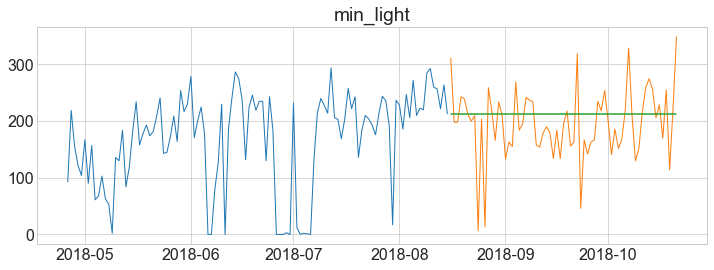

min_fair -- RMSE: 18


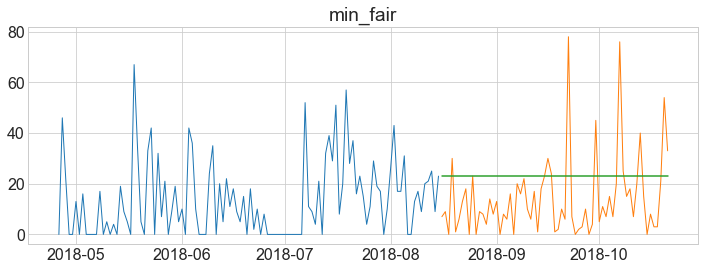

min_very -- RMSE: 38


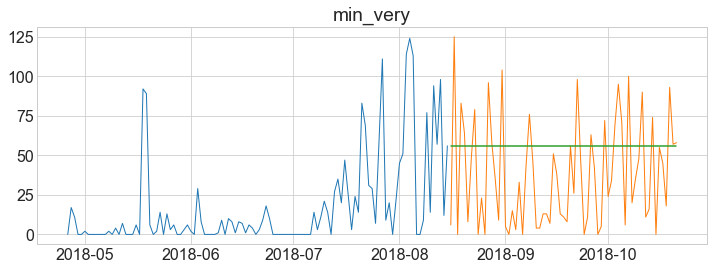

In [43]:
# plot predicted values
for col in train.columns:
    plot_and_eval(col)

In [44]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

In [45]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,cal_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,min_sed,163.0
3,last_observed_value,min_light,64.0
4,last_observed_value,min_fair,18.0
5,last_observed_value,min_very,38.0


### Simple Average

In [46]:
# get average and use that to make predictions for all in validate
cal_burned = train['cal_burned'].mean()
steps = train['steps'].mean()
min_sed = train['min_sed'].mean()
min_light = train['min_light'].mean()
min_fair = train['min_fair'].mean()
min_very = train['min_very'].mean()

# create function for later repitition
def make_predictions():
    yhat_df = pd.DataFrame({'cal_burned': [cal_burned], 'steps': [steps], 'min_sed': [min_sed], 
                        'min_light': [min_light], 'min_fair': [min_fair], 'min_very': [min_very]}, 
                           index = validate.index)
    return yhat_df

yhat_df = make_predictions()

In [47]:
yhat_df.head(2)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-08-16,3246.803571,5962.517857,916.928571,168.446429,13.776786,17.660714
2018-08-17,3246.803571,5962.517857,916.928571,168.446429,13.776786,17.660714


cal_burned -- RMSE: 658


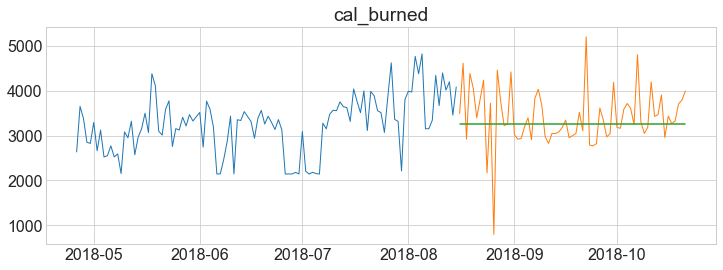

steps -- RMSE: 5356


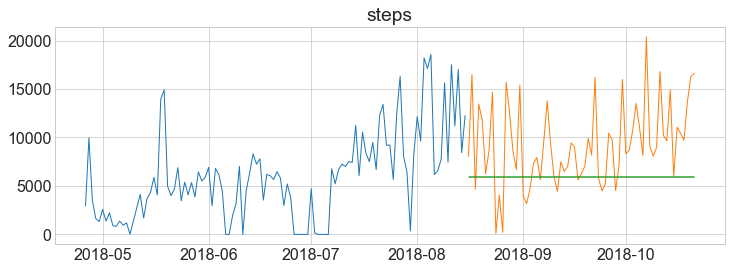

min_sed -- RMSE: 233


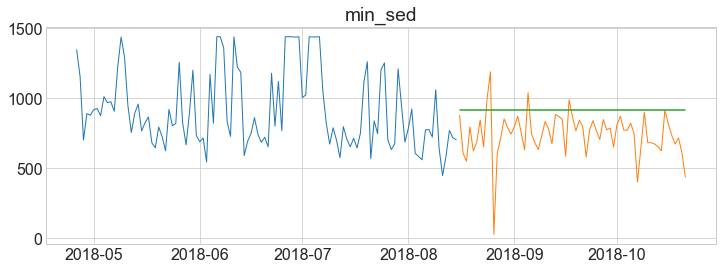

min_light -- RMSE: 68


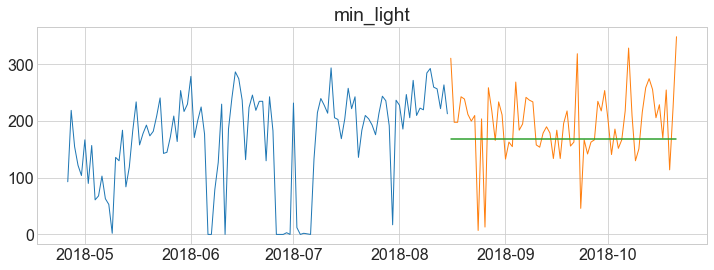

min_fair -- RMSE: 16


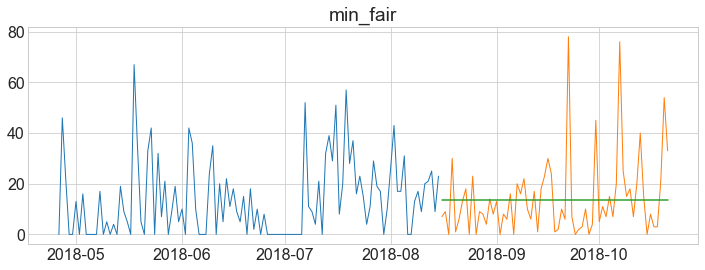

min_very -- RMSE: 39


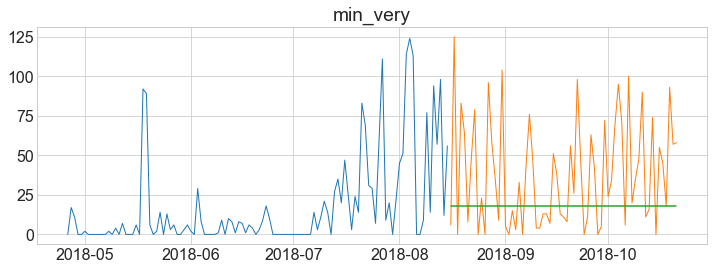

In [48]:
for col in train.columns:
    plot_and_eval(col)

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)

In [50]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,cal_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,min_sed,163.0
3,last_observed_value,min_light,64.0
4,last_observed_value,min_fair,18.0
5,last_observed_value,min_very,38.0
6,simple_average,cal_burned,658.0
7,simple_average,steps,5356.0
8,simple_average,min_sed,233.0
9,simple_average,min_light,68.0


### 30 day rolling average

In [51]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 
period = 30

cal_burned = round(train['cal_burned'].rolling(period).mean().iloc[-1], 1)
steps = round(train['steps'].rolling(period).mean().iloc[-1], 1)
min_sed = round(train['min_sed'].rolling(period).mean().iloc[-1], 1)
min_light = round(train['min_light'].rolling(period).mean().iloc[-1], 1)
min_fair = round(train['min_fair'].rolling(period).mean().iloc[-1], 1)
min_very = round(train['min_very'].rolling(period).mean().iloc[-1], 1)

yhat_df = make_predictions()
yhat_df.head(3)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-08-16,3774.3,10650.6,797.2,218.4,18.8,45.6
2018-08-17,3774.3,10650.6,797.2,218.4,18.8,45.6
2018-08-18,3774.3,10650.6,797.2,218.4,18.8,45.6


cal_burned -- RMSE: 732


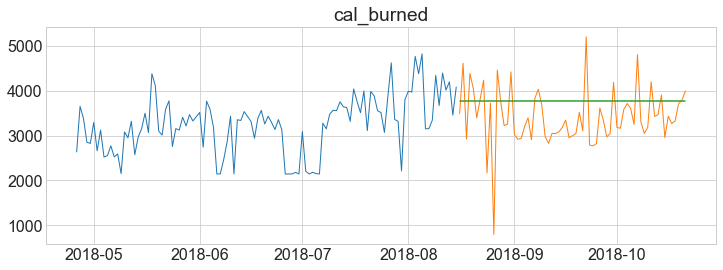

steps -- RMSE: 4425


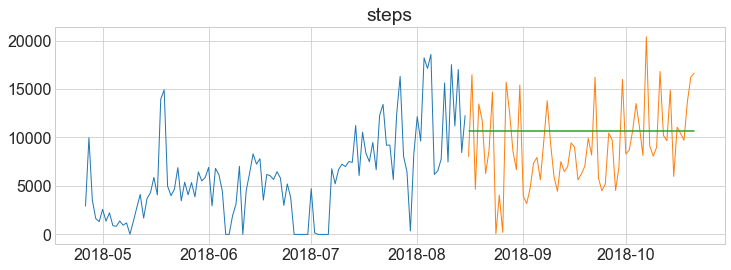

min_sed -- RMSE: 166


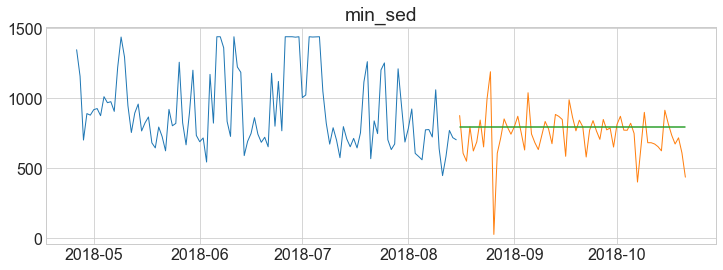

min_light -- RMSE: 66


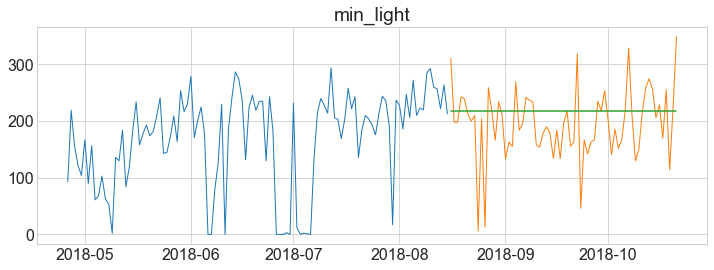

min_fair -- RMSE: 16


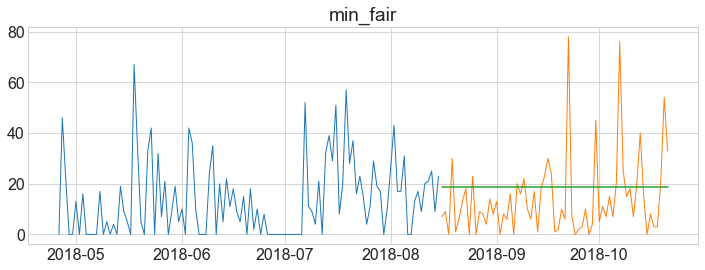

min_very -- RMSE: 34


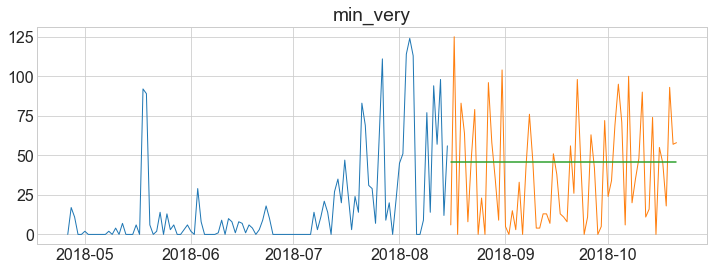

In [52]:
for col in train.columns:
    plot_and_eval(col)

In [53]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)

In [54]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,cal_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,min_sed,163.0
3,last_observed_value,min_light,64.0
4,last_observed_value,min_fair,18.0
5,last_observed_value,min_very,38.0
6,simple_average,cal_burned,658.0
7,simple_average,steps,5356.0
8,simple_average,min_sed,233.0
9,simple_average,min_light,68.0


#### additional rolling average periods

In [55]:
periods = [1, 7, 12, 26, 52, 104]

for p in periods:
    cal_burned = round(train['cal_burned'].rolling(period).mean().iloc[-1], 1)
    steps = round(train['steps'].rolling(period).mean().iloc[-1], 1)
    min_sed = round(train['min_sed'].rolling(period).mean().iloc[-1], 1)
    min_light = round(train['min_light'].rolling(period).mean().iloc[-1], 1)
    min_fair = round(train['min_fair'].rolling(period).mean().iloc[-1], 1)
    min_very = round(train['min_very'].rolling(period).mean().iloc[-1], 1)
    yhat_df = make_predictions()
    model_type = str(p) + 'd moving average'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [56]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,cal_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,min_sed,163.0
3,last_observed_value,min_light,64.0
4,last_observed_value,min_fair,18.0
5,last_observed_value,min_very,38.0
6,simple_average,cal_burned,658.0
7,simple_average,steps,5356.0
8,simple_average,min_sed,233.0
9,simple_average,min_light,68.0


### Best Model so far

In [57]:
# get the min rmse for each variable

# min_rmse_cb = eval_df.groupby('target_var')['rmse'].min()[0]
# min_rmse_min_fair = eval_df.groupby('target_var')['rmse'].min()[1]
# min_rmse_min_light = eval_df.groupby('target_var')['rmse'].min()[2]
# min_rmse_min_sed = eval_df.groupby('target_var')['rmse'].min()[3]
# min_rmse_min_very = eval_df.groupby('target_var')['rmse'].min()[-2]
# min_rmse_steps = eval_df.groupby('target_var')['rmse'].min()[-1]

# # filter only the rows that match those rmse to find out 
# # which models are best thus far
# eval_df[((eval_df.rmse == min_rmse_cb) | 
#          (eval_df.rmse == min_rmse_min_fair) | (eval_df.rmse == min_rmse_min_light) | 
#          (eval_df.rmse == min_rmse_min_sed) | (eval_df.rmse == min_rmse_min_very) | 
#          (eval_df.rmse == min_rmse_steps)
#         )]

eval_df.groupby(['target_var', 'model_type'])[['rmse']].min()

rmse
target_var model_type                 
cal_burned 104d moving average   732.0
           12d moving average    732.0
           1d moving average     732.0
           26d moving average    732.0
           30d moving average    732.0
           52d moving average    732.0
           7d moving average     732.0
           last_observed_value   921.0
           simple_average        658.0
min_fair   104d moving average    16.0
           12d moving average     16.0
           1d moving average      16.0
           26d moving average     16.0
           30d moving average     16.0
           52d moving average     16.0
           7d moving average      16.0
           last_observed_value    18.0
           simple_average         16.0
min_light  104d moving average    66.0
           12d moving average     66.0
           1d moving average      66.0
           26d moving average     66.0
           30d moving average     66.0
           52d moving average     66.0
           7d moving average      66.0
           last_observed_value    64.0
           simple_average         68.0
min_sed    104d moving average   166.0
           12d moving average    166.0
           1d moving average     166.0
           26d moving average    166.0
           30d moving average    166.0
           52d moving average    166.0
           7d moving average     166.0
           last_observed_value   163.0
           simple_average        233.0
min_very   104d moving average    34.0
           12d moving average     34.0
           1d moving average      34.0
           26d moving average     34.0
           30d moving average     34.0
           52d moving average     34.0
           7d moving average      34.0
           last_observed_value    38.0
           simple_average         39.0
steps      104d moving average  4425.0
           12d moving average   4425.0
           1d moving average    4425.0
           26d moving average   4425.0
           30d moving average   4425.0
           52d moving average   4425.0
           7d moving average    4425.0
           last_observed_value  5156.0
           simple_average       5356.0

- Best so far = any of rolling average

### Holts Linear Trend

cal_burned 



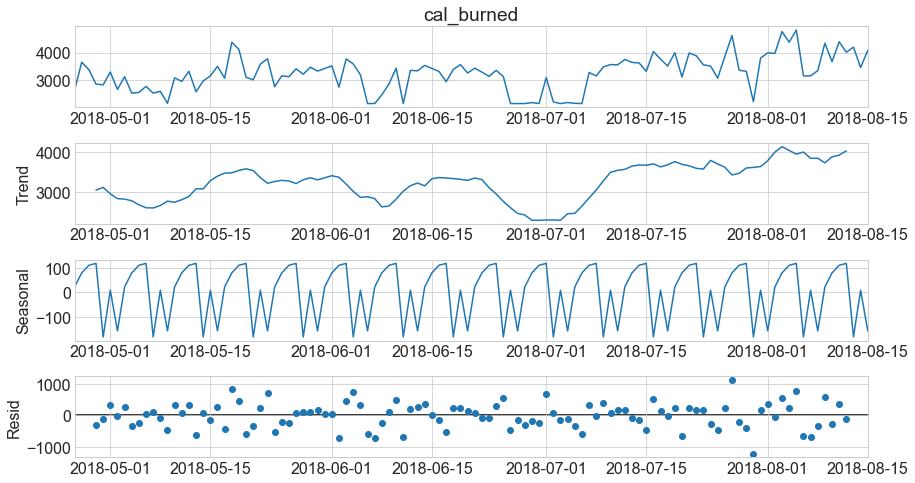

steps 



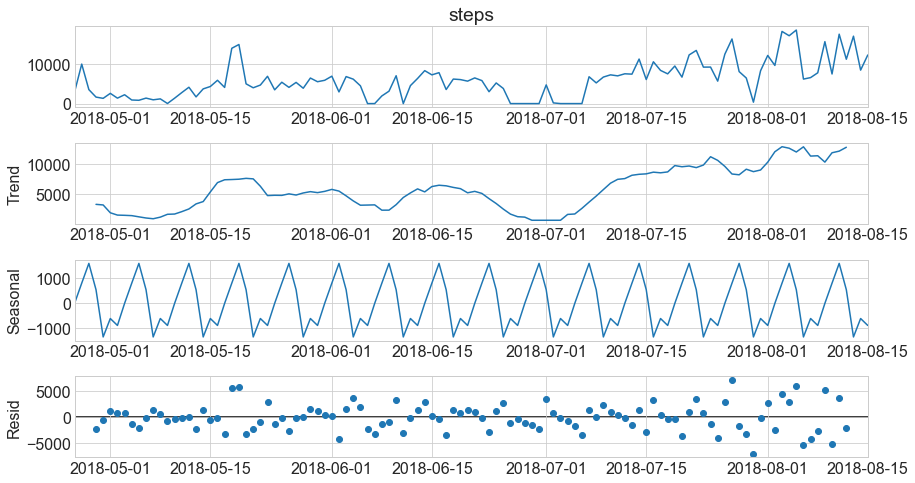

min_sed 



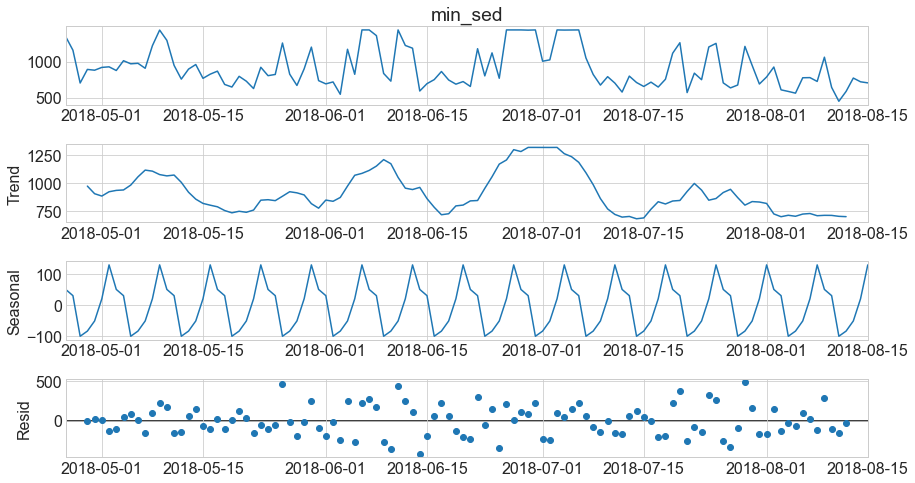

min_light 



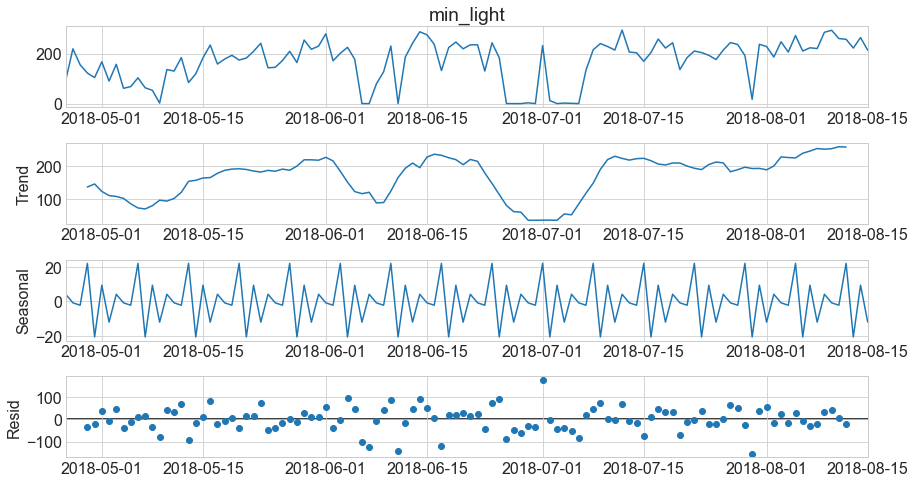

min_fair 



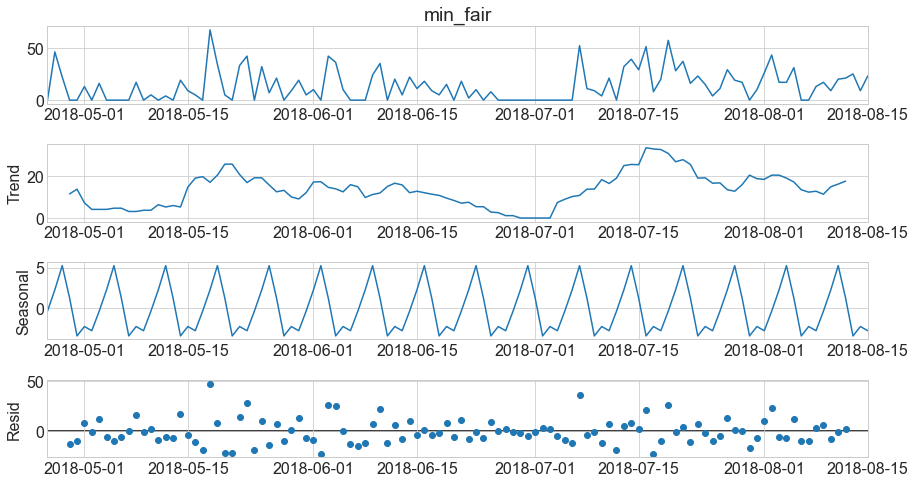

min_very 



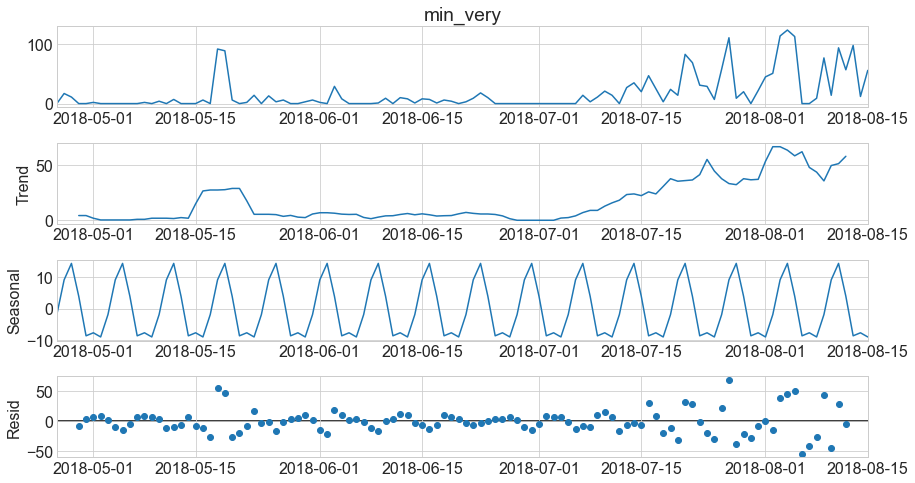

In [58]:
for col in train.columns:
    print(col,'\n')
    _ = sm.tsa.seasonal_decompose(train[col].resample('D').mean()).plot()
    plt.show()

In [59]:
for col in train.columns:
    model = Holt(train[col], exponential = False, damped=True)
    model = model.fit(smoothing_level = .1, 
                      smoothing_slope = .1, 
                      optimized = True)
    yhat_items = model.predict(start = validate.index[0], 
                               end = validate.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [60]:
yhat_df.head()

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-08-16,4070.95,13271.04,658.63,257.02,16.91,56.77
2018-08-17,4082.58,13394.04,651.68,259.14,16.92,57.09
2018-08-18,4094.08,13515.80,644.80,261.25,16.94,57.39
2018-08-19,4105.48,13636.35,637.98,263.33,16.95,57.68
2018-08-20,4116.75,13755.70,631.24,265.39,16.96,57.94


cal_burned -- RMSE: 1170


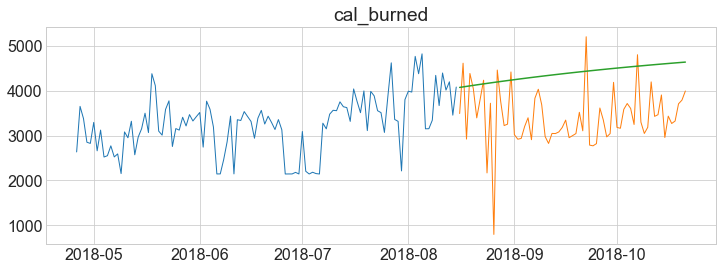

steps -- RMSE: 8370


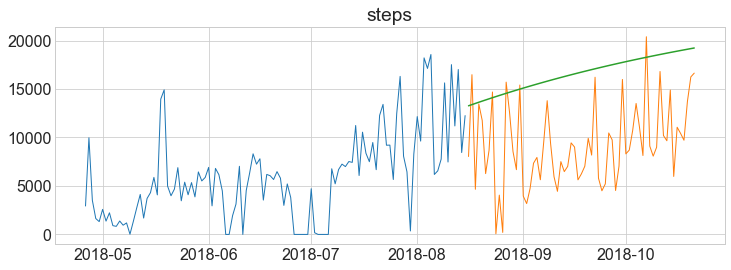

min_sed -- RMSE: 328


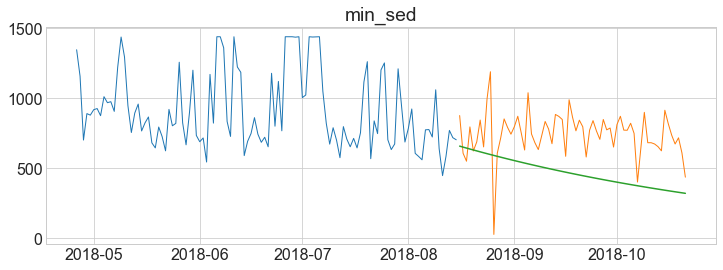

min_light -- RMSE: 135


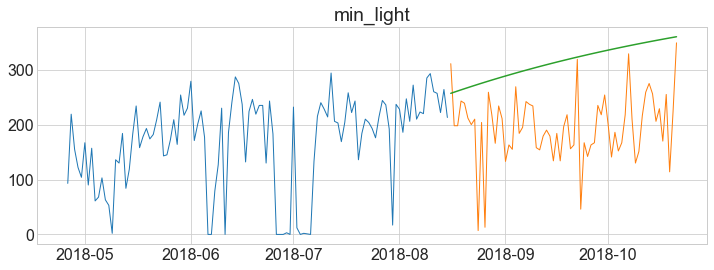

min_fair -- RMSE: 16


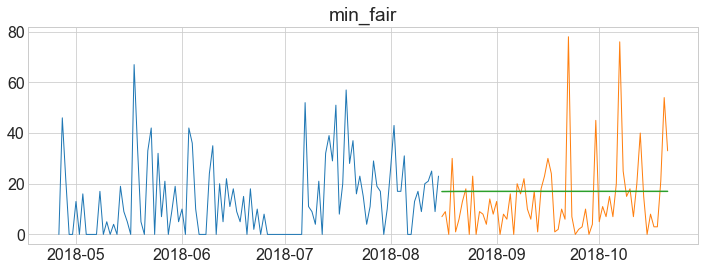

min_very -- RMSE: 40


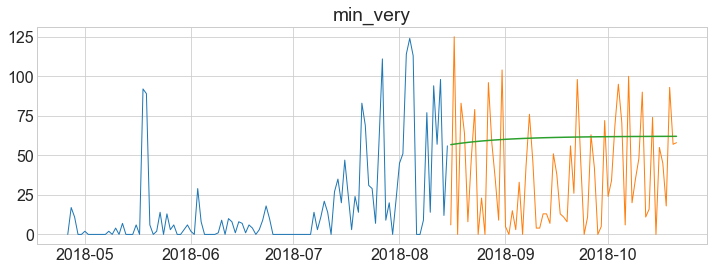

In [61]:
for col in train.columns:
    plot_and_eval(target_var = col)

In [62]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'Holts', 
                             target_var = col)

In [63]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,cal_burned,921.0
1,last_observed_value,steps,5156.0
2,last_observed_value,min_sed,163.0
3,last_observed_value,min_light,64.0
4,last_observed_value,min_fair,18.0
5,last_observed_value,min_very,38.0
6,simple_average,cal_burned,658.0
7,simple_average,steps,5356.0
8,simple_average,min_sed,233.0
9,simple_average,min_light,68.0


### Predict on previous cycle

Not going to use this model because data does not have seasonal/cycle in it

## Best model evaluation and test

- best performing models are the rolling average, no difference between # of days
- will use 7 days and try on test data

In [64]:
eval_df.groupby(['target_var', 'model_type'])[['rmse']].min()

rmse
target_var model_type                 
cal_burned 104d moving average   732.0
           12d moving average    732.0
           1d moving average     732.0
           26d moving average    732.0
           30d moving average    732.0
           52d moving average    732.0
           7d moving average     732.0
           Holts                1170.0
           last_observed_value   921.0
           simple_average        658.0
min_fair   104d moving average    16.0
           12d moving average     16.0
           1d moving average      16.0
           26d moving average     16.0
           30d moving average     16.0
           52d moving average     16.0
           7d moving average      16.0
           Holts                  16.0
           last_observed_value    18.0
           simple_average         16.0
min_light  104d moving average    66.0
           12d moving average     66.0
           1d moving average      66.0
           26d moving average     66.0
           30d moving average     66.0
           52d moving average     66.0
           7d moving average      66.0
           Holts                 135.0
           last_observed_value    64.0
           simple_average         68.0
min_sed    104d moving average   166.0
           12d moving average    166.0
           1d moving average     166.0
           26d moving average    166.0
           30d moving average    166.0
           52d moving average    166.0
           7d moving average     166.0
           Holts                 328.0
           last_observed_value   163.0
           simple_average        233.0
min_very   104d moving average    34.0
           12d moving average     34.0
           1d moving average      34.0
           26d moving average     34.0
           30d moving average     34.0
           52d moving average     34.0
           7d moving average      34.0
           Holts                  40.0
           last_observed_value    38.0
           simple_average         39.0
steps      104d moving average  4425.0
           12d moving average   4425.0
           1d moving average    4425.0
           26d moving average   4425.0
           30d moving average   4425.0
           52d moving average   4425.0
           7d moving average    4425.0
           Holts                8370.0
           last_observed_value  5156.0
           simple_average       5356.0

In [65]:
test_eval = pd.DataFrame(eval_df[eval_df.model_type == '7d moving average'])
test_eval

,model_type,target_var,rmse
24,7d moving average,cal_burned,732.0
25,7d moving average,steps,4425.0
26,7d moving average,min_sed,166.0
27,7d moving average,min_light,66.0
28,7d moving average,min_fair,16.0
29,7d moving average,min_very,34.0


In [69]:
# concat train and validate to move to test stage
train_val = train.append(validate)

In [71]:
train.shape, validate.shape, train_val.shape

((112, 6), (67, 6), (179, 6))

In [72]:
# compute a 7 day rolling average, 
 
period = 7

cal_burned = round(train_val['cal_burned'].rolling(period).mean().iloc[-1], 1)
steps = round(train_val['steps'].rolling(period).mean().iloc[-1], 1)
min_sed = round(train_val['min_sed'].rolling(period).mean().iloc[-1], 1)
min_light = round(train_val['min_light'].rolling(period).mean().iloc[-1], 1)
min_fair = round(train_val['min_fair'].rolling(period).mean().iloc[-1], 1)
min_very = round(train_val['min_very'].rolling(period).mean().iloc[-1], 1)

yhat_df = pd.DataFrame({'cal_burned': [cal_burned], 'steps': [steps], 'min_sed': [min_sed], 
                        'min_light': [min_light], 'min_fair': [min_fair], 'min_very': [min_very]}, 
                           index = test.index)
yhat_df.head(3)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-10-22,3494.9,11968.9,701.4,221.0,17.4,46.6
2018-10-23,3494.9,11968.9,701.4,221.0,17.4,46.6
2018-10-24,3494.9,11968.9,701.4,221.0,17.4,46.6


In [73]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label = 'validate')
    plt.plot(test[target_var], label = 'test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

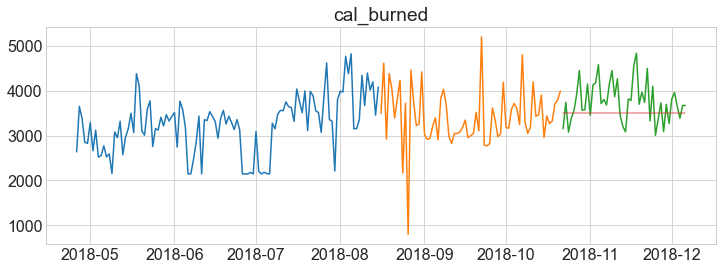

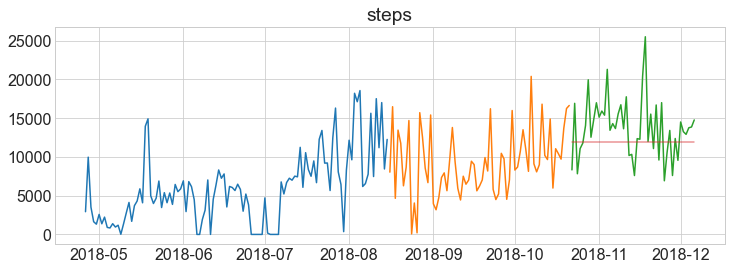

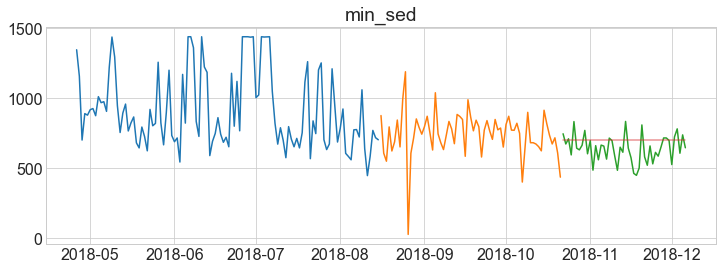

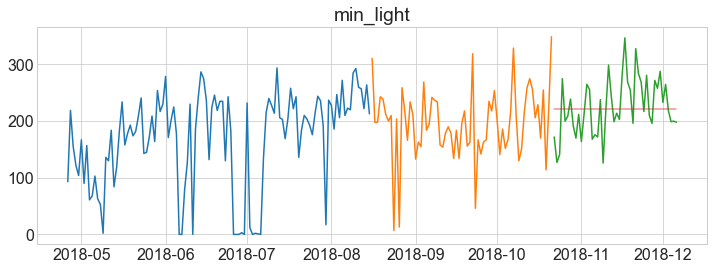

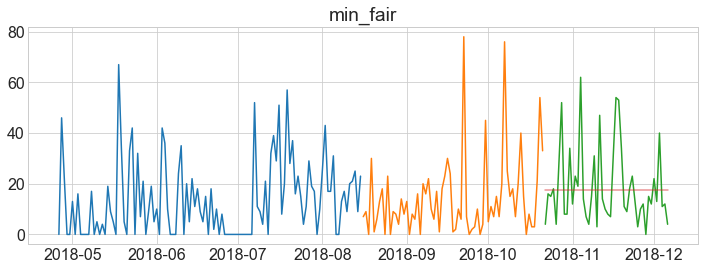

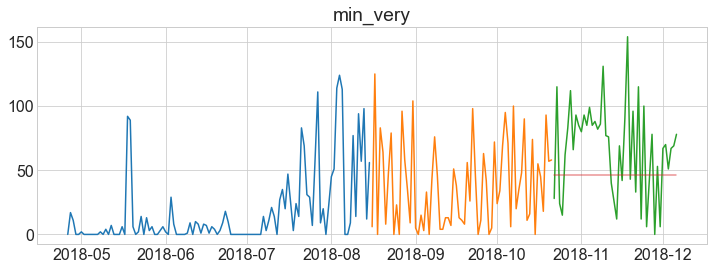

In [74]:
for col in train.columns:
    final_plot(col)

In [75]:
rmse_cal_burned = sqrt(mean_squared_error(test['cal_burned'], yhat_df['cal_burned']))
rmse_steps = sqrt(mean_squared_error(test['steps'], yhat_df['steps']))
rmse_min_sed = sqrt(mean_squared_error(test['min_sed'], yhat_df['min_sed']))
rmse_min_light = sqrt(mean_squared_error(test['min_light'], yhat_df['min_light']))
rmse_min_fair = sqrt(mean_squared_error(test['min_fair'], yhat_df['min_fair']))
rmse_min_very = sqrt(mean_squared_error(test['min_very'], yhat_df['min_very']))

print('rmse_cal_burned=', rmse_cal_burned)
print('rmse_steps=', rmse_steps)
print('rmse_min_sed=', rmse_min_sed)
print('rmse_min_light=', rmse_min_light)
print('rmse_min_fair=', rmse_min_fair)
print('rmse_min_very=', rmse_min_very)

rmse_cal_burned= 514.6297035142165
rmse_steps= 4141.3349991539435
rmse_min_sed= 111.5630412543197
rmse_min_light= 49.59049698585756
rmse_min_fair= 15.235513432937447
rmse_min_very= 40.4181835962156


In [76]:
def final_evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [77]:
# function to store rmse for comparison purposes
def final_append_eval_df(model_type, target_var):
    rmse = final_evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return test_eval.append(d, ignore_index = True)

In [78]:
for col in train.columns:
    test_eval = final_append_eval_df(model_type = '7d test', 
                             target_var = col)

In [79]:
test_eval

,model_type,target_var,rmse
0,7d moving average,cal_burned,732.0
1,7d moving average,steps,4425.0
2,7d moving average,min_sed,166.0
3,7d moving average,min_light,66.0
4,7d moving average,min_fair,16.0
5,7d moving average,min_very,34.0
6,7d test,cal_burned,515.0
7,7d test,steps,4141.0
8,7d test,min_sed,112.0
9,7d test,min_light,50.0


In [80]:
# concat train and validate and test make future predictions
train_val_test = train_val.append(test)

In [82]:
# compute a 7 day rolling average using test, 
# predict out 2 weeks based on this average for next 2 weeks predictions
period = 7

cal_burned = round(train_val_test['cal_burned'].rolling(period).mean().iloc[-1], 1)
steps = round(train_val_test['steps'].rolling(period).mean().iloc[-1], 1)
min_sed = round(train_val_test['min_sed'].rolling(period).mean().iloc[-1], 1)
min_light = round(train_val_test['min_light'].rolling(period).mean().iloc[-1], 1)
min_fair = round(train_val_test['min_fair'].rolling(period).mean().iloc[-1], 1)
min_very = round(train_val_test['min_very'].rolling(period).mean().iloc[-1], 1)

yhat_df = pd.DataFrame({'cal_burned': [cal_burned], 'steps': [steps], 'min_sed': [min_sed], 
                        'min_light': [min_light], 'min_fair': [min_fair], 'min_very': [min_very]}, 
                           index = test.index + pd.Timedelta('2W'))
yhat_df.head(3)

,cal_burned,steps,min_sed,min_light,min_fair,min_very
date,,,,,,
2018-11-05,3631.7,13234.7,675.3,228.9,16.3,58.3
2018-11-06,3631.7,13234.7,675.3,228.9,16.3,58.3
2018-11-07,3631.7,13234.7,675.3,228.9,16.3,58.3


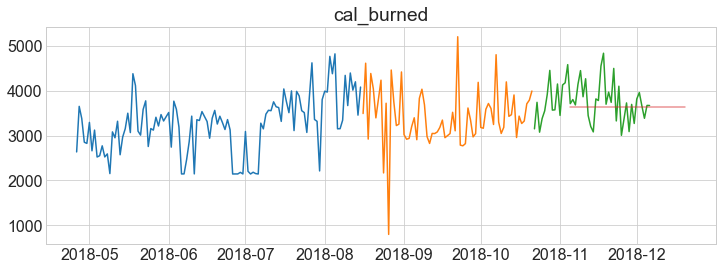

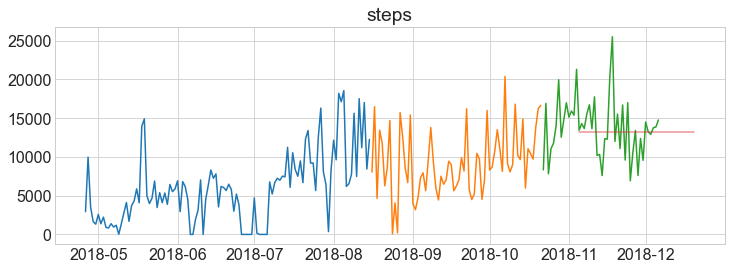

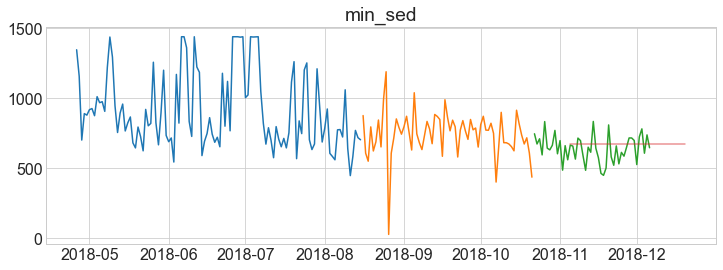

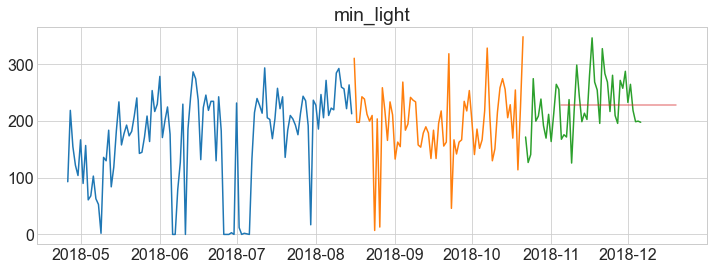

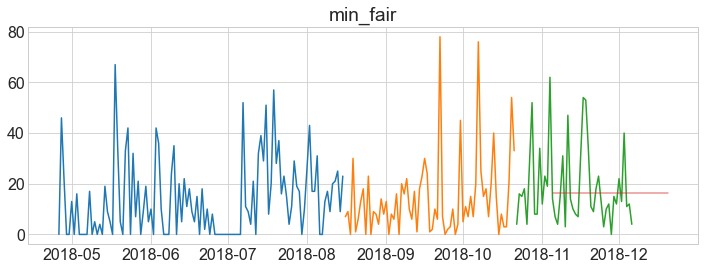

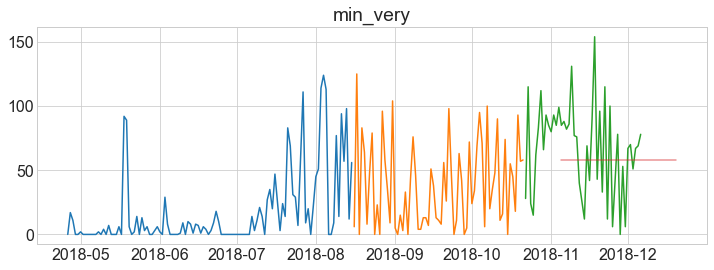

In [83]:
# visual with future 2 week forecast
for col in train.columns:
    final_plot(col)

In [84]:
baseline = pd.DataFrame(eval_df[eval_df.model_type == 'simple_average'])
baseline

,model_type,target_var,rmse
6,simple_average,cal_burned,658.0
7,simple_average,steps,5356.0
8,simple_average,min_sed,233.0
9,simple_average,min_light,68.0
10,simple_average,min_fair,16.0
11,simple_average,min_very,39.0


In [85]:
test_eval

,model_type,target_var,rmse
0,7d moving average,cal_burned,732.0
1,7d moving average,steps,4425.0
2,7d moving average,min_sed,166.0
3,7d moving average,min_light,66.0
4,7d moving average,min_fair,16.0
5,7d moving average,min_very,34.0
6,7d test,cal_burned,515.0
7,7d test,steps,4141.0
8,7d test,min_sed,112.0
9,7d test,min_light,50.0


In [86]:
# Calcuating % improvement
# First: work out the difference (increase) between the two numbers you are comparing
base_error = baseline.rmse.sum()
test_error = test_eval[test_eval.model_type =='7d test'].rmse.sum()
difference = (base_error - test_error)
# Then: divide the increase by the original number and multiply the answer by 100
percent_improve = round((difference / base_error) * 100, 2)
print(f'The % improvement for our model is {percent_improve}%')

The % improvement for our model is 23.5%


<a id='Summary'></a>

# Deliverables

## Summary of Data

- dataset is fairly small, only late April - early Dec is represented
- there is no seasonal or cyclical trend in the data
- there is a slight upward trend in calories burned and minutes of higher levels of activity over time
- the number of minutes of fair, or very active is highest on the weekends
- the best performing model for prediction is a rolling average
    - there was no difference in predictions based on the period of the rolling average however
- if a simple average model is taken as the baseline, then the 7 day rolling average model performed better than the baseline by 24%

## Conclusions

- given the levels of sedentary and light activity minutes during the week and higher activity levels on the weekends it is likely this person works at a desk or other sedentary position
- the slight upward trend overall seems to indicate this person is attempting to increase their activity levels over time
- given that the 7 day rolling average is the best predicting model it is likely this trend will continue

## 2 week prediction csv

In [87]:
# create csv of 2 week predictions
yhat_df.to_csv('predictions_2weeks')